## Train a model with Mushroom data using XGBoost algorithm
### Model is trained with XGBoost installed in notebook instance
_In the later examples, we will train using SageMaker's XGBoost algorithm_

In [ ]:
!pip3 install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
columns = ['class_edible', 'cap-shape', 'cap-surface', 'cap-color', 'bruises',
       'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']

In [ ]:
df = pd.read_csv('mushroom_data_all.csv')

In [ ]:
df.head()

In [ ]:
df['class_edible'].value_counts()

In [ ]:
pd.crosstab(df.class_edible,df.class_edible)

In [ ]:
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

In [ ]:
# Encoding the variable
df = df.apply(lambda x: d[x.name].fit_transform(x))

In [ ]:
df.head()

In [ ]:
d.keys()

In [ ]:
for key in d.keys():
    print(key, d[key].classes_)

In [ ]:
df['class_edible'].value_counts()


In [ ]:
df.to_csv('mushroom_encoded_all.csv'
                          ,index=False)

## Training and Validation Set¶


In [ ]:
# Training = 70% of the data
# Validation = 30% of the data
# Randomize the datset
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.iloc[l]

In [ ]:
rows = df.shape[0]
train = int(.7 * rows)
test = rows-train

In [ ]:
rows, train, test

In [ ]:
# Write Training Set
df[:train].to_csv('mushroom_train.csv'
                          ,index=False,index_label='Row',header=False
                          ,columns=columns)

In [ ]:
# Write Validation Set
df[train:].to_csv('mushroom_validation.csv'
                          ,index=False,index_label='Row',header=False
                          ,columns=columns)

In [ ]:
# Write Column List
with open('mushroom_train_column_list.txt','w') as f:
    f.write(','.join(columns))

#  Train. * test. Split

In [ ]:
from sklearn.model_selection import train_test_split
X=df.drop( "class_edible", axis=1)
y=df.class_edible
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)


In [ ]:
x_train.shape

In [ ]:
X.shape[0]

In [ ]:
y_test.head()

In [ ]:
x_test.head()

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
column_list_file = 'mushroom_train_column_list.txt'
train_file = 'mushroom_train.csv'
validation_file = 'mushroom_validation.csv'

In [ ]:
columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [ ]:
columns

In [ ]:
# Specify the column names as the file does not have column header
df_train = pd.read_csv(train_file,names=columns)
df_validation = pd.read_csv(validation_file,names=columns)

In [ ]:
df_train.head()

In [ ]:
df_validation.head()

In [ ]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:]
y_validation = df_validation.iloc[:,0] ##.ravel()

In [ ]:
y_validation

In [ ]:
# Launch a classifier
# XGBoost Training Parameter Reference: 
#   https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
#classifier = xgb.XGBClassifier (objective='binary:logistic',n_estimators=50)
classifier = xgb.XGBClassifier (objective='binary:logistic')

In [ ]:
classifier

In [ ]:
classifier.fit(X_train,
               y_train,
               eval_set = [(X_train, y_train), (X_validation, y_validation)], 
               eval_metric=['logloss'])

In [ ]:
eval_result = classifier.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['logloss']))

In [ ]:
eval_result

In [ ]:
training_rounds

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['logloss'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['logloss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
tmp=pd.DataFrame(eval_result)


In [ ]:
tmp.columns

In [ ]:
tmp.validation_0

In [ ]:
tmp=tmp['validation_0']['logloss'][0]+0.2

In [ ]:
tmp['validation_0']['logloss']

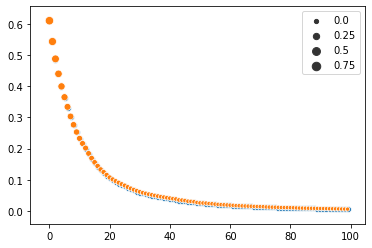

In [300]:
fig, ax = plt.subplots()
sns.scatterplot(x=training_rounds, y=tmp['validation_0']['logloss'],   data=tmp, ax=ax)
sns.scatterplot(x=training_rounds, y=tmp['validation_1']['logloss'],size=tmp['validation_1']['logloss'],  data=tmp, ax=ax)

In [ ]:
xgb.plot_importance(classifier)
plt.show()

In [ ]:
df = pd.read_csv(validation_file,names=columns)

In [ ]:
df.head()


In [ ]:
X_test = df.iloc[:,1:]

In [ ]:
result = classifier.predict(X_test)

In [ ]:
result[:5]

In [ ]:
df['predicted_class'] = result

In [ ]:
df.iloc[:, 0:3].head()

In [ ]:
df.head()

In [ ]:
df.class_edible.value_counts()

In [ ]:
df.predicted_class.value_counts()

# Binary Classifier Metrics

In [301]:

# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred): 
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [ ]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References: 
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix
    
    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)
    
    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive
    
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)
    
    positive = tp + fn
    negative = tn + fp
    
    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn
    
    metrics['Positive'] = positive
    metrics['Negative'] = negative
    
    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive
        
    metrics['Recall'] = recall
    
    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr
    
    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision
    
    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy
    
    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr
    
    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr
    
    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:        
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1
    
    return metrics

In [ ]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:

# Compute confusion matrix
#{0:'edible',1:'poisonous'})
cnf_matrix = confusion_matrix(df['class_edible'], df['predicted_class'],labels=[1,0])

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Poisonous','Edible'],
                      title='Confusion Matrix')

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Poisonous','Edible'],
                      title='Confusion Matrix',normalize=True)

In [ ]:
metrics = [binary_classifier_metrics(df['class_edible'], df['predicted_class'])]
df_metrics=pd.DataFrame.from_dict(metrics)
df_metrics.index = ['Model']

In [ ]:
df_metrics

In [ ]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

In [ ]:
print(classification_report(
    df['class_edible'],
    df['predicted_class'],
    labels=[1,0],
    target_names=['Poisonous','Edible']))